# Main Code

## Inputs

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Normalization, Flatten
from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, average_precision_score
import matplotlib.pyplot as plt
import shap

## Important Variables

In [2]:
EPOCHS = 100
BATCH_SIZE = 2

In [3]:
shap.initjs()
tf.compat.v1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


## Input Sorting

In [4]:
t1_meningioma = pd.read_csv('T1_Meningioma.csv')
t2_meningioma = pd.read_csv('T2_Meningioma.csv')

for i in t1_meningioma.columns:
    t1_meningioma.rename(columns = {i: "t1_" + i}, inplace = True)
    
for i in t2_meningioma.columns:
    t2_meningioma.rename(columns = {i: "t2_" + i}, inplace = True)
    
clinical      = pd.read_csv('Clinical.csv')
clinical["Pathologic grade"] = LabelEncoder().fit_transform(clinical["Pathologic grade"])
clinical["Sex"] = LabelEncoder().fit_transform(clinical["Sex"])
clinical["Grouped location"] = LabelEncoder().fit_transform(clinical["Grouped location"])

#Train data
clinical_data = clinical.drop("Pathologic grade", axis = 1)
# Target
target = clinical.drop(['Sex', 'Grouped location', 'Age'],axis = 1)
# Concat
data = pd.concat([clinical_data,t1_meningioma,t2_meningioma], axis=1)

device = tf.config.list_physical_devices('GPU')
patients = len(data)

## Main

In [5]:
# Standardize the data
scaler = StandardScaler() 
scaler = scaler.fit(data[data.columns])

#Stratified to keep the same class splitting, random state set so that its the same one every time.
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.25, random_state = 2021, stratify=target)

x_train[x_train.columns] = scaler.transform(x_train[x_train.columns])
x_test[x_test.columns] = scaler.transform(x_test[x_test.columns])

model = tf.keras.Sequential([
    tf.keras.layers.Normalization(input_shape=[217,]),
    tf.keras.layers.Dense(217, activation = 'relu'),
    tf.keras.layers.Dense(108, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
],
                            name = 'model',
                            )

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy']
)

# Commented out to keep results consistant, don't re-run the code as the output will change
#model.fit(x_train, y_train, epochs = EPOCHS, batch_size = BATCH_SIZE)


Train on 72 samples
Epoch 1/100
72/72 [==============================] - 0s 3ms/sample - loss: 0.7261 - acc: 0.5417
Epoch 2/100
72/72 [==============================] - 0s 1ms/sample - loss: 0.4225 - acc: 0.7917
Epoch 3/100
72/72 [==============================] - 0s 1ms/sample - loss: 0.2774 - acc: 0.8750
Epoch 4/100
72/72 [==============================] - 0s 2ms/sample - loss: 0.2185 - acc: 0.9306
Epoch 5/100
72/72 [==============================] - 0s 1ms/sample - loss: 0.1584 - acc: 0.9583
Epoch 6/100
72/72 [==============================] - 0s 2ms/sample - loss: 0.1340 - acc: 0.9861
Epoch 7/100
72/72 [==============================] - 0s 1ms/sample - loss: 0.0559 - acc: 1.0000
Epoch 8/100
72/72 [==============================] - 0s 1ms/sample - loss: 0.0361 - acc: 1.0000
Epoch 9/100
72/72 [==============================] - 0s 1ms/sample - loss: 0.0216 - acc: 1.0000
Epoch 10/100
72/72 [==============================] - 0s 1ms/sample - loss: 0.0149 - acc: 1.0000
Epoch 11/100
72/72 

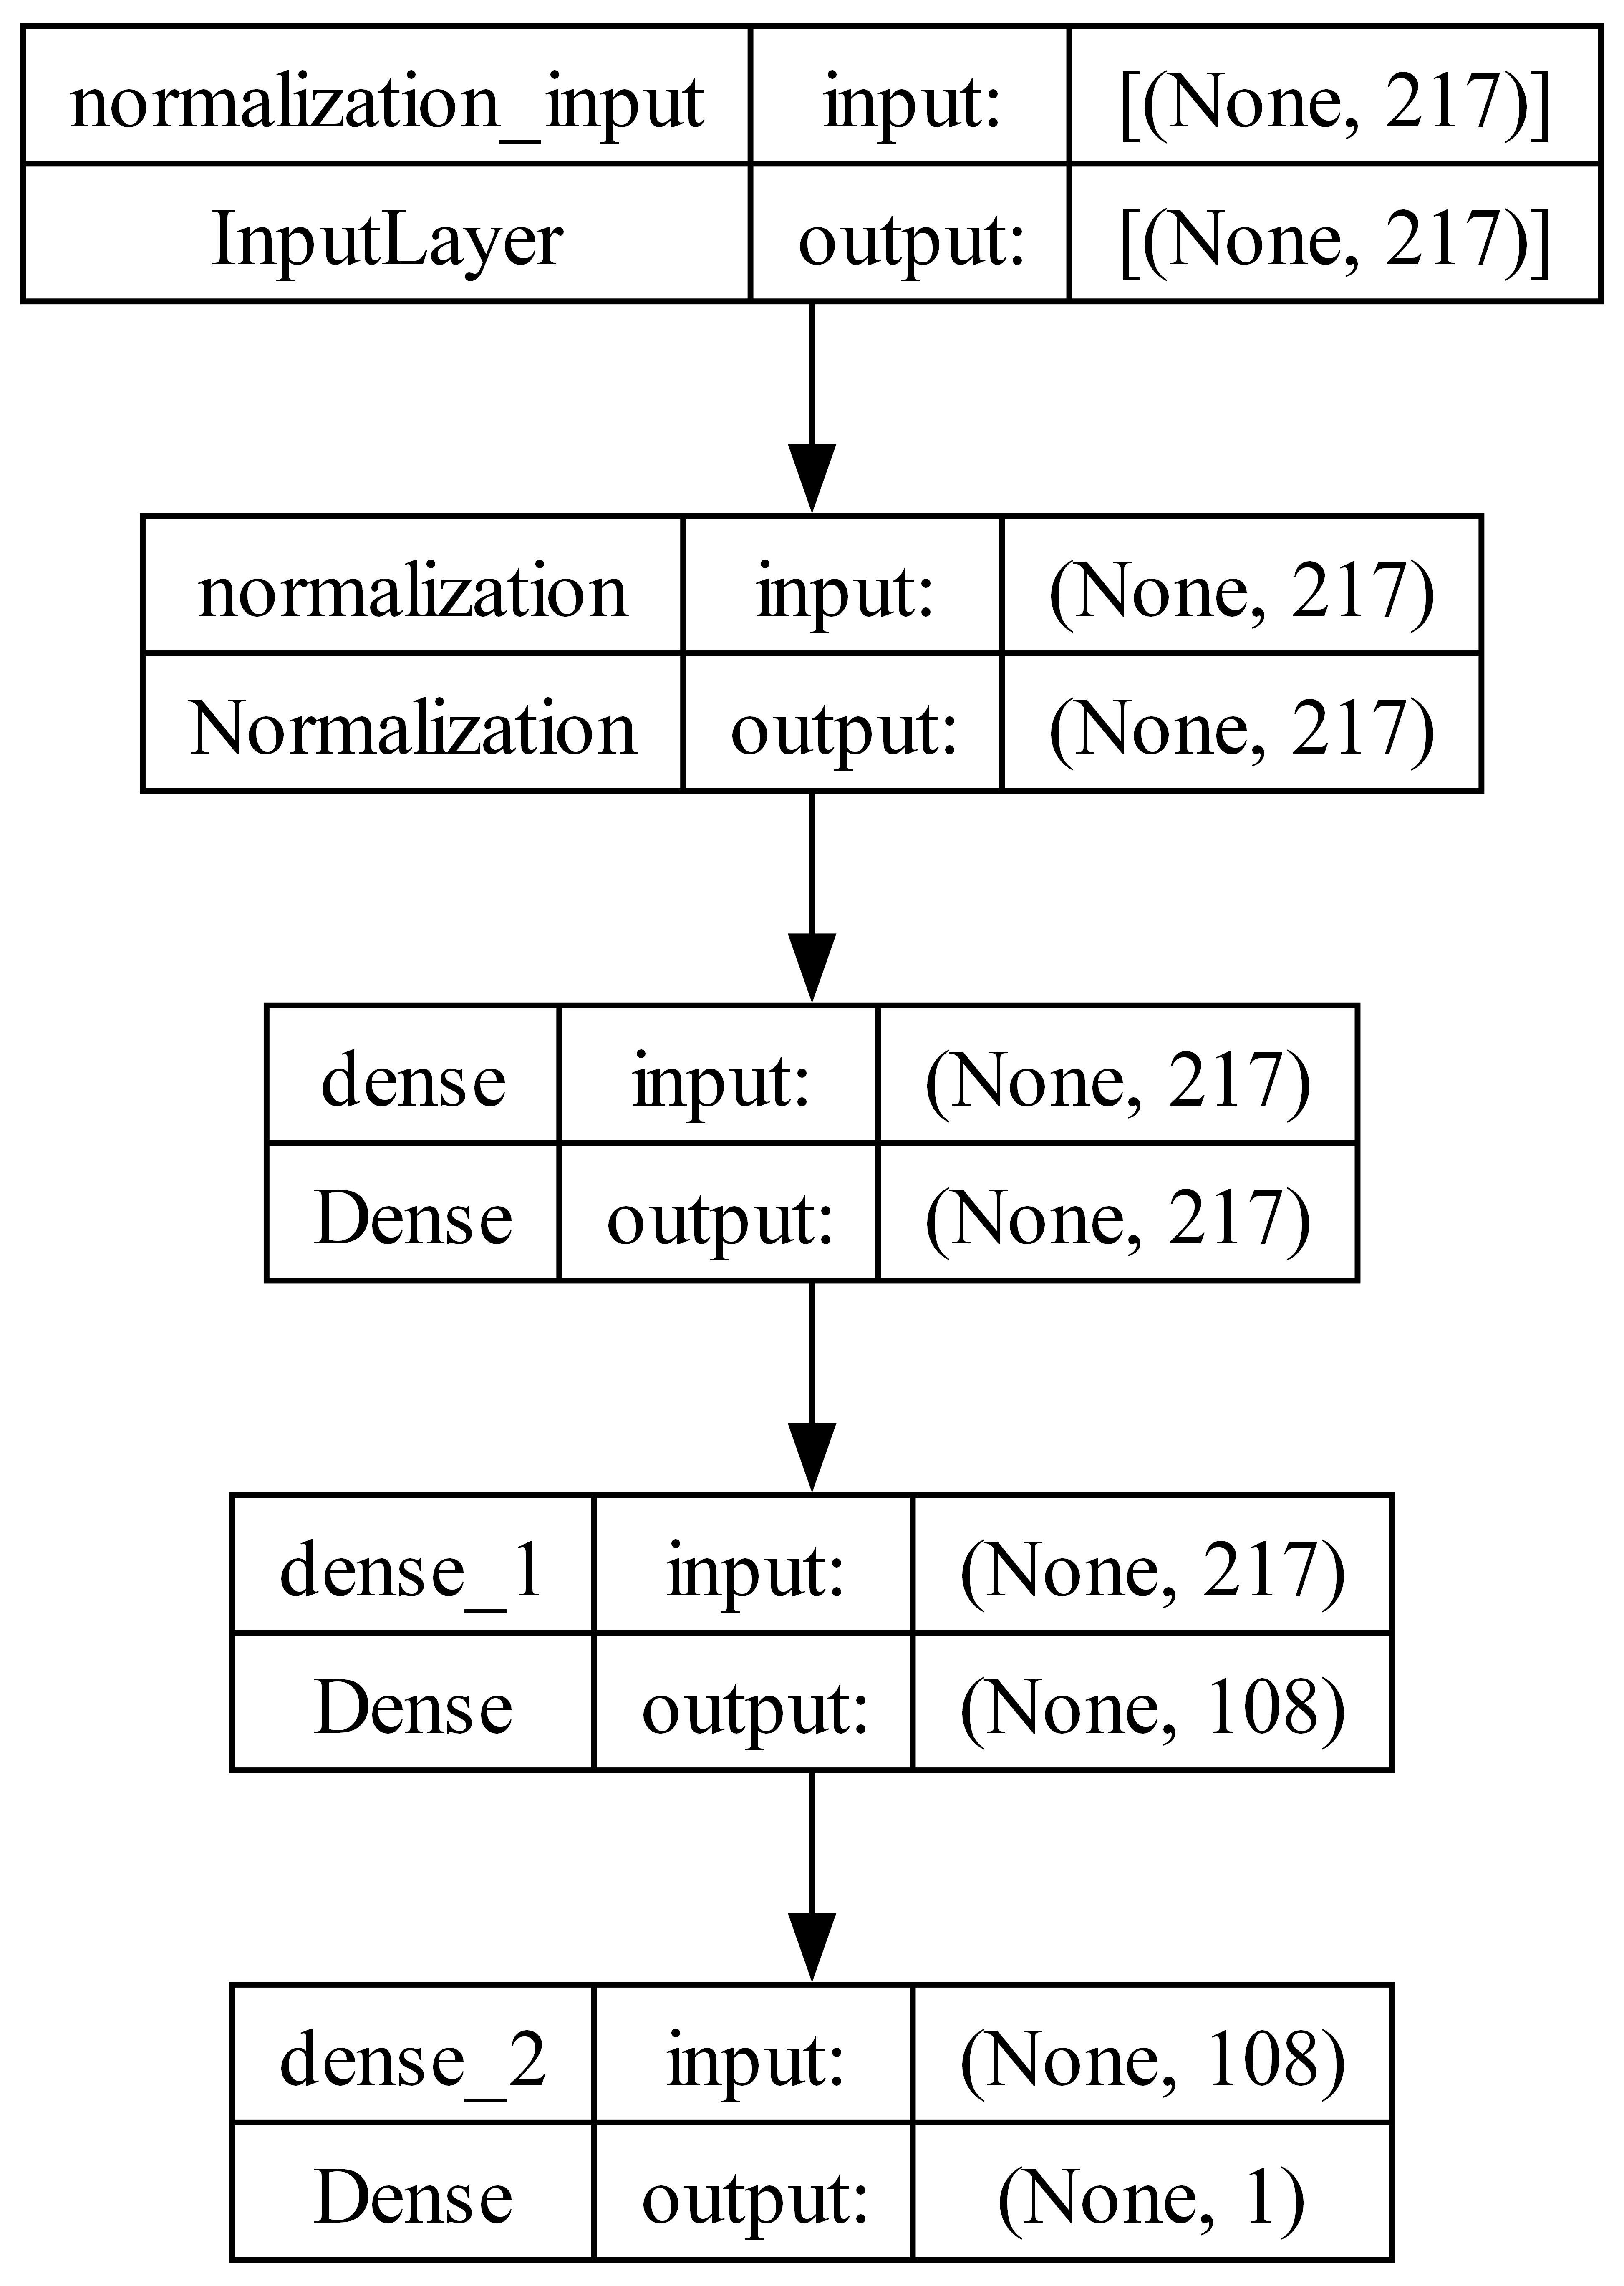

In [6]:
from keras.utils.vis_utils import plot_model
import os

os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'
plot_model(model, show_shapes = True, dpi = 1000)

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Test Acc:  0.7083333333333334
Test F1:   0.631578947368421
Test Precision:  0.6666666666666666
Test Recall:  0.6
ROC AUC Score:  0.6928571428571428
Precision-Recall AUC Score :  0.7621212121212121


Text(0.5, 1.0, 'Test Confusion Matrix')

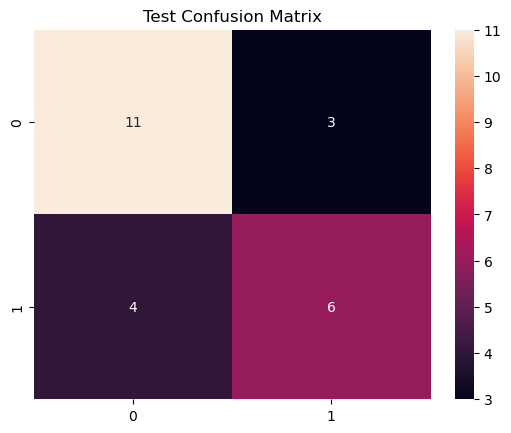

In [7]:
import seaborn as sns

predicted = model.predict(x_test)

test_accuracy = accuracy_score(y_test, predicted.round())
test_f1 = f1_score(y_test, predicted.round())
test_precision = precision_score(y_test, predicted.round())
test_recall = recall_score(y_test, predicted.round())
test_roc_auc = roc_auc_score(y_test, predicted.round())
precision_recall_curve = average_precision_score(y_test, predicted)
cm = confusion_matrix(y_test, predicted.round())
print("Test Acc: ", test_accuracy)
print("Test F1:  ", test_f1)
print("Test Precision: ", test_precision)
print("Test Recall: ", test_recall)
print("ROC AUC Score: ", test_roc_auc)
print("Precision-Recall AUC Score : ", precision_recall_curve)
sns.heatmap(cm, annot=True)
plt.title("Test Confusion Matrix")

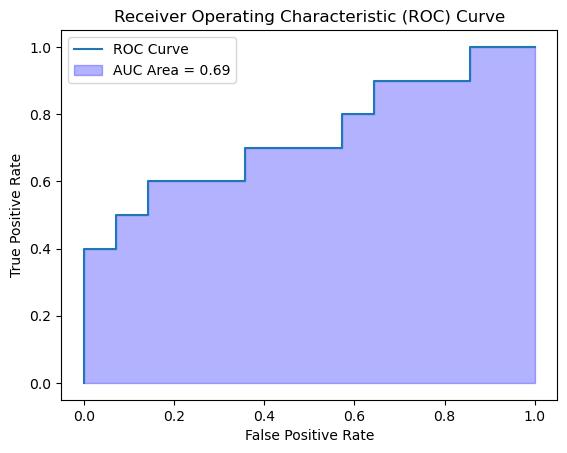

In [8]:
# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, predicted)

plt.figure()
plt.plot(fpr, tpr, label='ROC Curve ')
plt.fill_between(fpr, tpr, alpha=0.3, color='b', label=f'AUC Area = {test_roc_auc:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


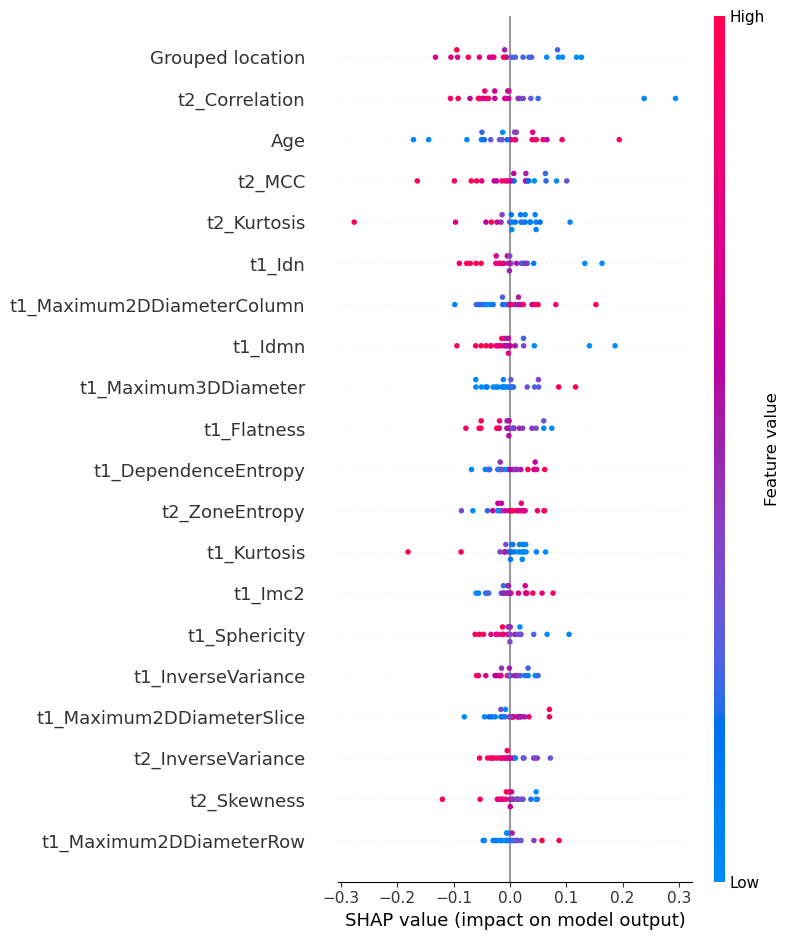

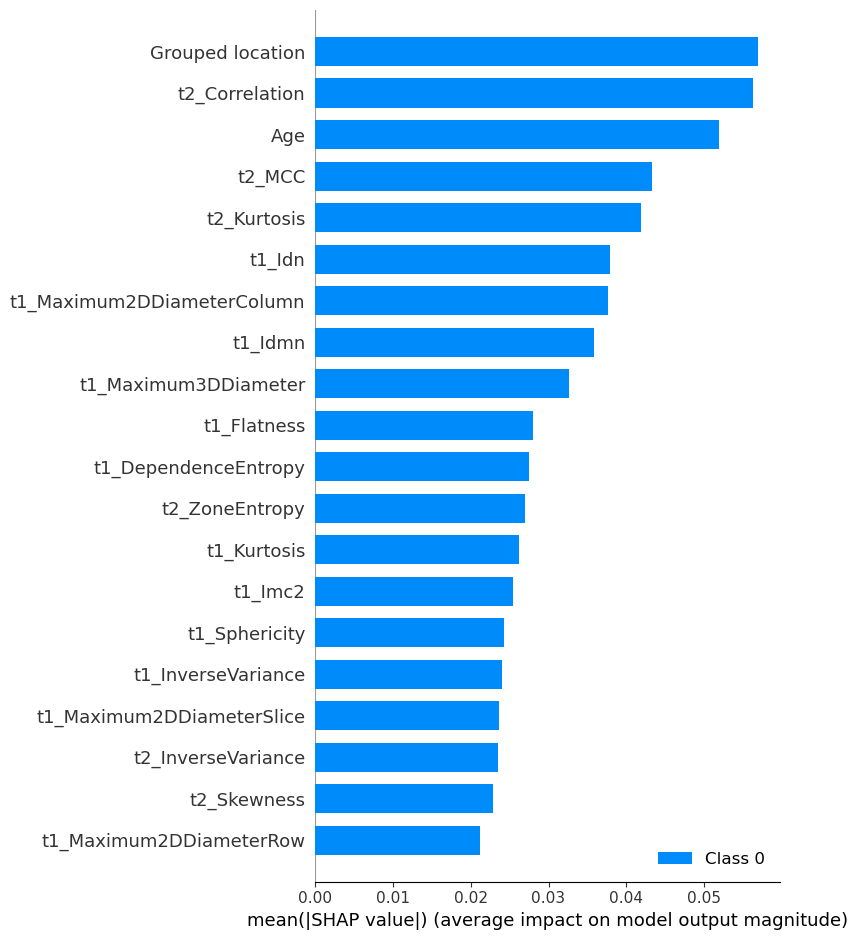

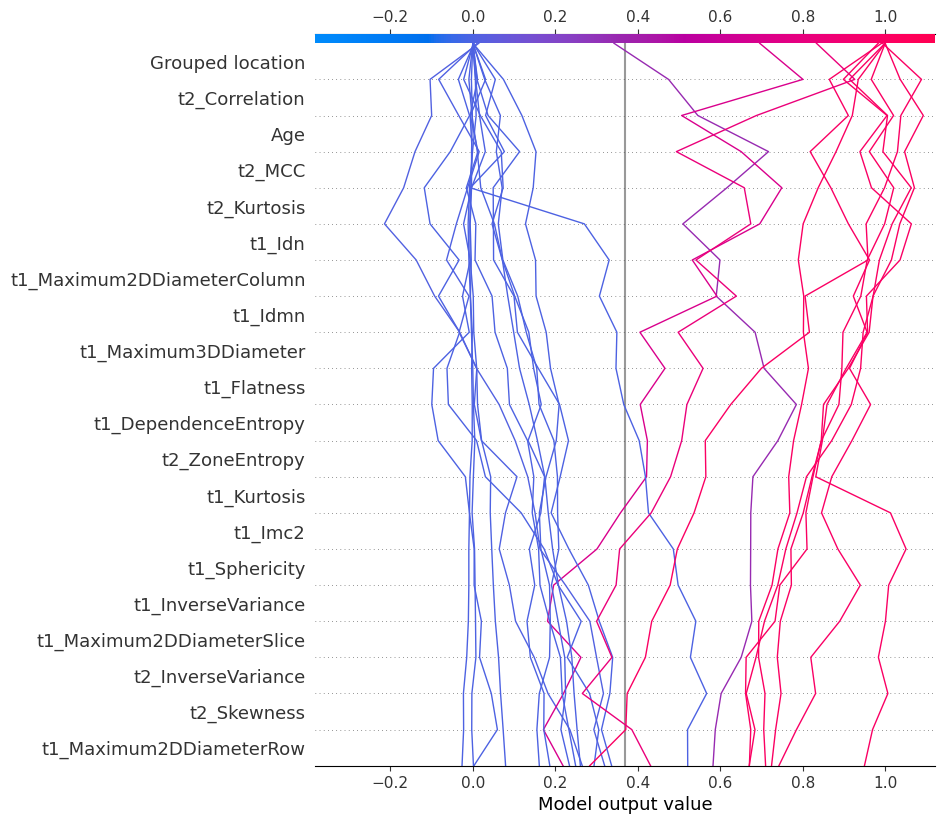

In [9]:
test_explainer = shap.DeepExplainer(model, x_test,)
explainer = shap.Explainer(model, x_test)

shap_values= test_explainer.shap_values(x_test.values)

shap.summary_plot(shap_values[0], x_test) 
shap.summary_plot(shap_values, x_test,) 
shap.decision_plot(test_explainer.expected_value[0], shap_values[0], x_test)

In [10]:
output_directory = "..\\Trial_00\\waterfallplots\\"
correct_counter = 0
incorrect_counter = 0

for i in range(len(x_test)):
    is_correct_prediction = y_test.values[i] == predicted[i].round()

    # Create a new figure for each plot
    plt.figure()

    if is_correct_prediction:
        plt.suptitle(f"Correct Prediction\nActual Label {y_test.values[i]} | Predicted Label {predicted[i].round()}")
        filename = f"waterfall_correct_{correct_counter}.png"
        correct_counter += 1
    else:
        plt.suptitle(f"Incorrect Prediction\nActual Label {y_test.values[i]} | Predicted Label {predicted[i].round()}")
        filename = f"waterfall_incorrect_{incorrect_counter}.png"
        incorrect_counter += 1

    # Plot the Shapley waterfall
    shap.waterfall_plot(shap.Explanation(shap_values[0][i], test_explainer.expected_value[0], x_test.iloc[i]), show=False)
    
    #Ensures y-axis labels don't get cut off
    plt.tight_layout()

    # Save the figure
    filepath = os.path.join(output_directory, filename)
    plt.savefig(filepath)
    plt.close()